## Data Load and Preparation

In [59]:
#Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import *
from network import *
from typing import Tuple
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
sns.set()
import missingno as msno
import tensorflow as tf
import os
import keras_tuner

In [61]:
#Changing directory
os.chdir('/Users/melihekinci/Documents/FAU_Courses/FirstSemester/MLTS/godaddy-microbusiness-density-forecasting/')

In [62]:
#Reading data
df_train=pd.read_csv("train.csv")

In [63]:
#Creating time index for the date variable
df_train["time_index"] = df_train.groupby("cfips").cumcount() + 1

In [64]:
data=df_train[['time_index','cfips','microbusiness_density']]

In [65]:
#creating target variable as 1 lag of microbusiness density
data['y']=data['microbusiness_density'].shift(-1)

/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_4854/2023499355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y']=data['microbusiness_density'].shift(-1)


In [66]:
#dropping null values
data=data.dropna()

In [67]:
#sorting dfata
data=data.sort_values(by=['cfips','time_index'], ascending=True)

In [68]:
data.tail()

,time_index,cfips,microbusiness_density,y
122259,34,56045,1.803249,1.803249
122260,35,56045,1.803249,1.803249
122261,36,56045,1.803249,1.785395
122262,37,56045,1.785395,1.785395
122263,38,56045,1.785395,1.785395


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122264 entries, 0 to 122263
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time_index             122264 non-null  int64  
 1   cfips                  122264 non-null  int64  
 2   microbusiness_density  122264 non-null  float64
 3   y                      122264 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 4.7 MB


In [72]:
#train test split: 30
train=data[data.time_index<=30]
test=data[data.time_index>30]

In [73]:
#getting x and y
train_X = train.drop(['y','cfips'], axis=1)
train_y = train['y']
test_X=test.drop(['y','cfips'], axis=1)
test_y=test['y']

In [74]:
#turning dataframes into numpy arrays
train_X = train_X.to_numpy().reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.to_numpy().reshape((test_X.shape[0], test_X.shape[1], 1))

In [75]:
train_X.shape

(94050, 2, 1)

## Model Building

In [76]:
from tensorflow import keras
from tensorflow.keras import layers

In [77]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [82]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [83]:
input_shape = train_X.shape[1:]
model = build_model(
    input_shape,
    head_size=512,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[64],
    mlp_dropout=0.1,
    dropout=0.25,
)

In [91]:
from keras import metrics
import tensorflow.keras.backend as K

#defining SMAPE loss metric
def smape_loss(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

#compiling the model
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_squared_error",metrics.mean_absolute_error, smape_loss],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 2, 1)]       0           []                               
                                                                                                  
 layer_normalization_60 (LayerN  (None, 2, 1)        2           ['input_10[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_30 (Multi  (None, 2, 1)        28673       ['layer_normalization_60[0][0]', 
 HeadAttention)                                                   'layer_normalization_60[0][0]'] 
                                                                                            

In [92]:
#fitting the model
model1=model.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=50,
    batch_size=1000,
    callbacks=callbacks,
)


Epoch 1/50
76/76 [==============================] - 54s 663ms/step - loss: 3.0007 - mean_squared_error: 3.0007 - mean_absolute_error: 0.2935 - smape_loss: 0.0850 - val_loss: 0.2482 - val_mean_squared_error: 0.2482 - val_mean_absolute_error: 0.1085 - val_smape_loss: 0.0315
Epoch 2/50
76/76 [==============================] - 50s 655ms/step - loss: 3.0814 - mean_squared_error: 3.0814 - mean_absolute_error: 0.2976 - smape_loss: 0.0882 - val_loss: 0.2306 - val_mean_squared_error: 0.2306 - val_mean_absolute_error: 0.1080 - val_smape_loss: 0.0348
Epoch 3/50
76/76 [==============================] - 50s 659ms/step - loss: 2.6304 - mean_squared_error: 2.6304 - mean_absolute_error: 0.2775 - smape_loss: 0.0806 - val_loss: 0.2810 - val_mean_squared_error: 0.2810 - val_mean_absolute_error: 0.2058 - val_smape_loss: 0.0806
Epoch 4/50
76/76 [==============================] - 51s 670ms/step - loss: 2.8385 - mean_squared_error: 2.8385 - mean_absolute_error: 0.2848 - smape_loss: 0.0848 - val_loss: 0.2711 

In [94]:
model.evaluate(test_X, test_y, verbose=1)

882/882 [==============================] - 10s 11ms/step - loss: 9.6384 - mean_squared_error: 9.6384 - mean_absolute_error: 0.4202 - smape_loss: 0.1023


[9.6383695602417, 9.6383695602417, 0.4202004671096802, 0.10229996591806412]

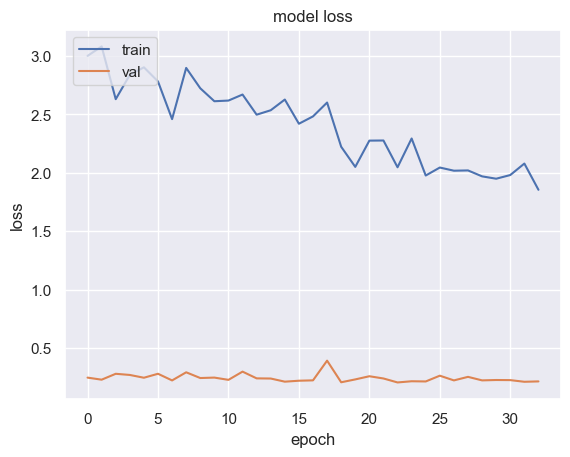

In [95]:
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Hyperparameter Tuning

In [271]:
import talos as ta

In [292]:
def transformer_model(x_train, y_train, x_val, y_val, params):
    def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
    ):
        inputs = keras.Input(shape=input_shape)
        x = inputs
        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(mlp_dropout)(x)
        outputs = layers.Dense(1)(x)
        return keras.Model(inputs, outputs)

    #input_shape = x_train.shape[1:]
    
    model = build_model(
        #input_shape,
        head_size=params['head_size'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        num_transformer_blocks=params['num_transformer_blocks'],
        mlp_units=params['mlp_units'],
        mlp_dropout=params['mlp_dropout'],
        dropout=params['dropout'],
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=params['lr']),
        metrics=["mean_squared_error"],
    )

    callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    
    history = model.fit(
        x_train,
        y_train,
        validation_data=[x_val, y_val],
        epochs=params['epoch'],
        batch_size=params['batch_size'],
        callbacks=callbacks)

    # finally we have to make sure that history object and model are returned
    return history, model


In [293]:

# then we can go ahead and set the parameter space
p = {'lr': (1e-4,0.5, 5),
     'head_size':[32,64,128],
     'num_heads':[2,4,8],
     'ff_dim': [2,4],
     'epochs': [50],
     'dropout': [0.25, 0.5],
     'num_transformer':[2,4,8],
     'mlp_units': [16,32,64],
     'mlp_dropout':[0.2, 0.4]}


In [ ]:
t = ta.Scan(x=train_X,
            y=train_y,
            model=transformer_model, 
            params=p,
            experiment_name='1')

## Prediction for Kaggle

In [214]:
#Reading test file
df_test=pd.read_csv("test.csv")

In [216]:
#splitting row_id to get cfips
df_test[['cfips', 'date']] = df_test.row_id.str.split("_", expand = True)

In [217]:
df_test=df_test.drop(columns=['row_id', 'date'])

In [219]:
#creating time index similarly as in the train data
df_test["time_index"] = df_test.groupby("cfips").cumcount() + 39

In [222]:
df_test.head()

,cfips,first_day_of_month,time_index
0,1001,2022-11-01,39
1,1003,2022-11-01,39
2,1005,2022-11-01,39
3,1007,2022-11-01,39
4,1009,2022-11-01,39


In [223]:
df_test=df_test.drop(columns=['first_day_of_month','cfips'])

In [224]:
#making dataframe into numpy array
df_test=df_test.to_numpy().reshape((df_test.shape[0], df_test.shape[1], 1))

In [225]:
df_test.shape

(25080, 1, 1)

In [226]:
df_test=np.asarray(df_test).astype('float32')

In [ ]:
predicted=model.predict(df_test, verbose=1)

In [210]:
predicted

array([[ 40.320683],
       [ 40.334045],
       [ 40.3474  ],
       ...,
       [368.5956  ],
       [368.60748 ],
       [368.61935 ]], dtype=float32)